# TensorFlow 2.0 alpha - Model Attention and Neural Machine Translation
### Use the Language dataset - containing language translation pairs

#### Train a sequence-to-sequence model for Spanish to English translation

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Download and Prepare Dataset

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+'/spa-eng/spa.txt'

### Prepare the Data as follows:
#### (1) Add start and end tokens to each sentence - (2) Clean sentences by removing special characters
#### (3) Create word index and reverse word index - (4) Pad each sentence to a max length

In [3]:
# convert the unicode file to ascii

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
# create a space between word and punctuation following it

    w = re.sub(r'([?.!,¿])', r' \1 ', w)
    w = re.sub(r'[" "]+', " ", w)
    
# replace everything with space except (a-z, A-Z, ".", "?", "!", ",")  

    w = re.sub(r'[^a-zA-Z?.!,¿]+', ' ', w)
    w = w.rstrip().strip()
    
# add start and end token - so model knows when to start/stop predicting

    w = '<start> ' + w + ' <end>'
    return w

In [4]:
en_sentence = u'May I borrow this book?'
sp_sentence = u'¿Puedo tomar prestado este libro?'

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [5]:
# remove the accents - clean sentences
# return word pairs in format - [ENGLISH, SPANISH]

def create_dataset(path, num_examples):
    lines = io.open(path, encoding='utf-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [6]:
en, sp = create_dataset(path_to_file, None)

print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post')
    
    return tensor, lang_tokenizer

In [9]:
def load_dataset(path, num_examples=None):
    
# create cleaned input, output pairs    
    
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

## Limit Dataset Size - Faster experimentation
#### Complete dataset > 100,000 sentences - limit to 30,000 sentences

In [10]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# calculate max_length of target tensors

max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [11]:
# create training and validation sets - use 80-20 split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# show length

len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [12]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print('%d ----> %s' % (t, lang.index_word[t]))

In [13]:
print('Input Language: index to word mapping')
convert(inp_lang, input_tensor_train[0])
print()
print('Target Language: index to word mapping')
convert(targ_lang, target_tensor_train[0])

Input Language: index to word mapping
1 ----> <start>
6 ----> ¿
83 ----> tienes
21 ----> una
622 ----> camara
14 ----> de
2143 ----> fotos
5 ----> ?
2 ----> <end>

Target Language: index to word mapping
1 ----> <start>
22 ----> do
6 ----> you
29 ----> have
9 ----> a
595 ----> camera
7 ----> ?
2 ----> <end>


## Create a tf.data.Dataset

In [14]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## Write Encoder and Decoder Model
#### Implement the Attention equations from seq2seq - assign a weight to input words, used by the decoder to predict

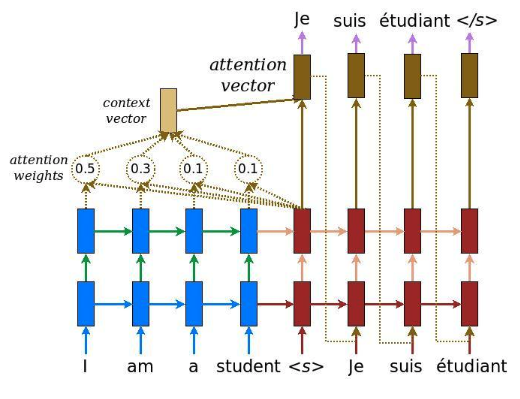

#### Attention Mechanisms - Attention Weights, Context Vector, Attention Vector, Luong's style, Bahdanau's style

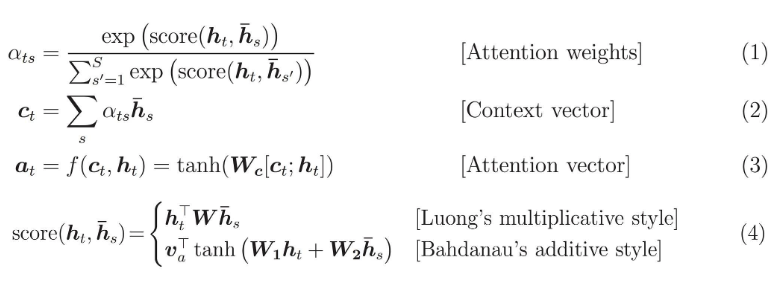

#### Input goes through an encoder model, giving encoder output of shape (*batch_size, max_length, hidden_size*) - and encoder hidden state of shape (*batch_size, hidden_size*)

### Using Bahdanau Attention - set the Notation
#### (1) FC = fully-connected Dense layer
#### (2) EO = Encoder output
#### (3) H = hidden state
#### (4) X = input
### Set the Psuedo-code
#### (1) *score* = FC(tanh(FC(EO) + FC(H)))
#### (2) *attention weights* = softmax(score, axis =1)
#### (3) *context vector* = sum(attention weights * EO, axis=1)
#### (4) *embedding output* = input to Decoder X, is passed through Embedding layer
#### (5) *merged vector* = concat(embedding output, context vector)
#### (6) this vector (merged), is given to GRU

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                               return_sequences = True,
                               return_state = True,
                               recurrent_initializer = 'glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [19]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print('Encoder output shape: (batch size, sequence length, units) {}'.format(
sample_output.shape))

print('Encoder Hidden state shape: (batch size, unit) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, unit) (64, 1024)


In [22]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

# hidden shape == (batch_size, hidden_size)
# hidden_with_time_axis == (batch_size, 1, hidden_size)
# THIS IS DONE to PERFORM ADDITION - to calculate score

# score shape == (batch_size, max_length, hidden_size)

# attention_weights shape == (batch_size, max_length, 1)
# get 1 at the last axis because applying score to self.V

# context_vector shape after sum == (batch_sizem hidden_size)
        
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights + values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden,
                                                     sample_output)

print('Attention Result shape: (batch_size, units) {}'.format(attention_result.shape))
print('Attention Weight shape: (batch_size, sequence_length, 1) {}'.format(attention_weights.shape))

Attention Result shape: (batch_size, units) (64, 1024)
Attention Weight shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [33]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                            return_sequences = True,
                                            return_state = True,
                                            recurrent_initializer = 'glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
# for Attention        
        
        self.attention = BahdanauAttention(self.dec_units)
        
# enc_output shape == (batch_size, max_length, hidden_size)
# x shape after passing through embedding == (batch_size, 1, embedding_dim) 
# x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size) 
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        
# passing the concatenated vector to the GRU
# output shape == (batch_size * 1, hidden_state) 
# output shape == (batch_size, vocab) 
        
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        
        return x, state, attention_weights

In [34]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)

print('Decoder Output shape: (batch_size, vocab_size) {}'.format(sample_decoder_output.shape))

Decoder Output shape: (batch_size, vocab_size) (64, 4935)


## Define Optimizer and Loss Function

In [35]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

## Checkpoints - Object-based saving

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                encoder=encoder,
                                decoder=decoder)

## Training
#### (1) pass Input through Encoder - returning Encoder_Output, and Encoder_Hidden_State
#### (2) Decoder Input (*start token*), Encoder_Output, and Encoder_Hidden_State - passed to Decoder
#### (3) Decoder returns Predictions and Decoder_Hidden_State
#### (4) Decoder_Hidden_State passed back into Model - Predictions used to calculate Loss
#### (5) use *Teacher Forcing* to decide Next Input to the Decoder
#### (6) Teacher Forcing - technique where Target_Word is passed as Next Input to the Decoder
#### (7) Final Step - calculate Gradients, apply to Optimizer, and Backpropogate

In [37]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
# Teacher Forcing - feeding target as next input
    # passing enc_output to Decoder
        
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(targ[:, t], predictions)
            
# using Teacher Forcing            
            
            dec_input = tf.expand_dims(targ[:, t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [39]:
EPOCHS = 8

for epoch in range(EPOCHS):
    start = time.time()
    
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, 
                                                         batch,
                                                         batch_loss.numpy()))
        
# Checkpoint - save the model every 2 epochs    
    
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.5723
Epoch 1 Batch 100 Loss 2.1920
Epoch 1 Batch 200 Loss 1.9362
Epoch 1 Batch 300 Loss 1.7135
Epoch 1 Loss 2.0070
Time taken for 1 epoch 1049.9630227088928 sec

Epoch 2 Batch 0 Loss 1.5025
Epoch 2 Batch 100 Loss 1.4326
Epoch 2 Batch 200 Loss 1.2894
Epoch 2 Batch 300 Loss 1.2036
Epoch 2 Loss 1.3318
Time taken for 1 epoch 1000.2354910373688 sec

Epoch 3 Batch 0 Loss 1.1109
Epoch 3 Batch 100 Loss 1.0740
Epoch 3 Batch 200 Loss 0.9297
Epoch 3 Batch 300 Loss 0.8793
Epoch 3 Loss 0.9681
Time taken for 1 epoch 967.9422538280487 sec

Epoch 4 Batch 0 Loss 0.8237
Epoch 4 Batch 100 Loss 0.7813
Epoch 4 Batch 200 Loss 0.6762
Epoch 4 Batch 300 Loss 0.6244
Epoch 4 Loss 0.6985
Time taken for 1 epoch 1019.0659110546112 sec

Epoch 5 Batch 0 Loss 0.5775
Epoch 5 Batch 100 Loss 0.5520
Epoch 5 Batch 200 Loss 0.4737
Epoch 5 Batch 300 Loss 0.4449
Epoch 5 Loss 0.4995
Time taken for 1 epoch 1463.0069272518158 sec

Epoch 6 Batch 0 Loss 0.4251
Epoch 6 Batch 100 Loss 0.3890
Epoch 6 Batch 200 

## Translate
#### The Evaluate Function is similar to the training loop - however, *Teacher Forcing* is NOT used
#### Instead, the Decoder Input at each time step is the Previous Predictions, along with Hidden State and Encoder Output
#### Stop predicting when model predicts *End Token*
#### Store Attention Weights for each time step

In [50]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen = max_length_inp,
                                                          padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)
# store attention weights to plot later        
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result += targ_lang.index_word[predicted_id] + ' '
        
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
# predicted ID is fed back into model        
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result, sentence, attention_plot

In [51]:
# Function for plotting attention weights

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 12}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    plt.show()

In [52]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    
    print('Input: %s' % (sentence))
    print('Predicted Translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the Latest Checkpoint, and Test Translations

In [53]:
# latest checkpoint in checkpoint_dir

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted Translation: it s very cold here . <end> 


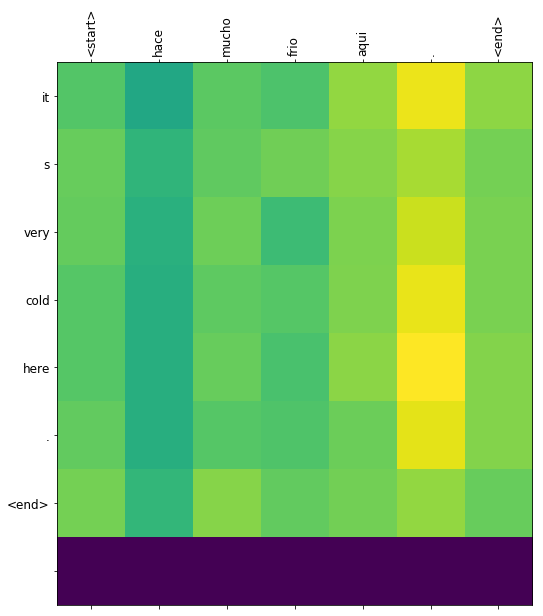

In [54]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted Translation: this is my life . <end> 


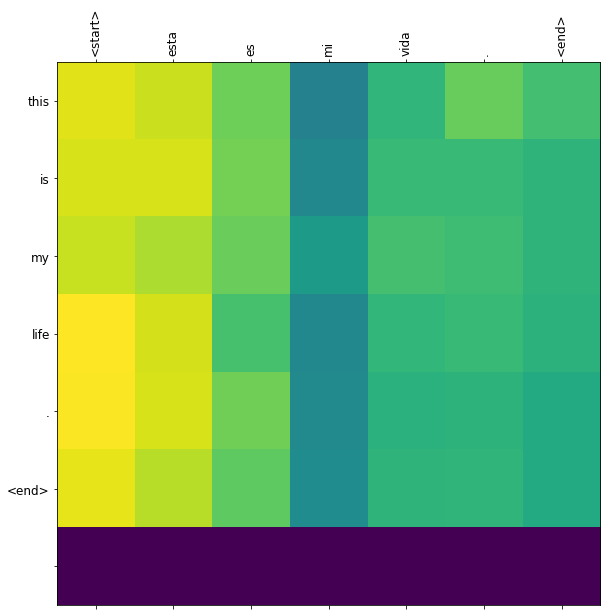

In [55]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted Translation: are you still at home ? <end> 


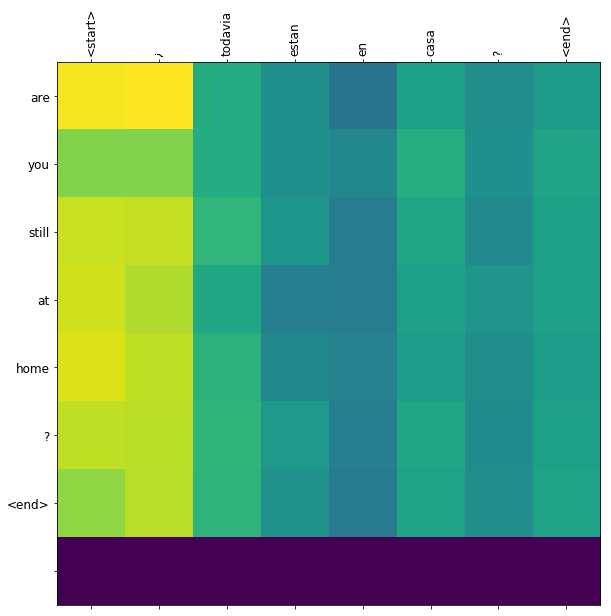

In [56]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted Translation: stop away . <end> 


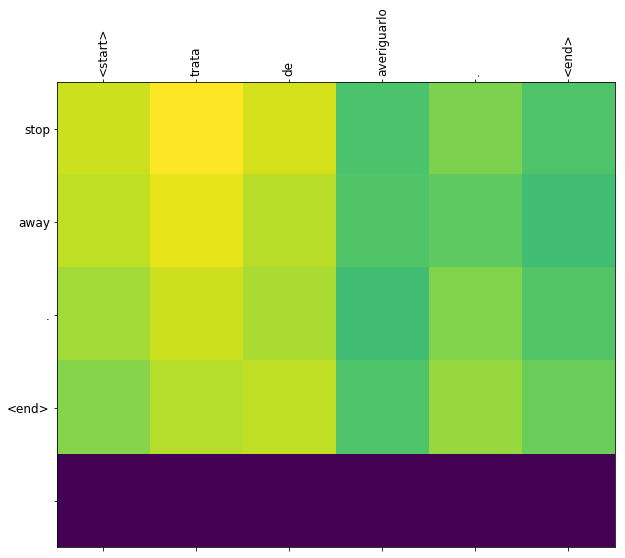

In [57]:
translate(u'trata de averiguarlo.')

#### This last translation was incorrect (actually means 'Try to find out') - NO dark green or blue here

# CONCLUSION
### The epochs could be completed much faster using gpu (instead of cpu), and more epochs could be used
### Different datasets could be used to translate different languages